In [1]:
!qbraid jobs enable amazon_braket
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx
from scipy.optimize import minimize
import json

from braket.aws import AwsDevice
from braket.devices import LocalSimulator

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

You have already enabled qBraid Quantum Jobs in the amazon_braket environment.


In [2]:
from qaoa import *
from iquhack_utils import *
from graph_tools import *

In [3]:
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Capabilities, constraints and performance metrics are stored as 'paradigm' attribute of AwsDevice.
capabilities = qpu.properties.paradigm
pp(capabilities.dict())

# get C6 coefficient in rad m^6/sec Pull from capabilities attribute
C6 = float(capabilities.rydberg.dict()['c6Coefficient'])

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

GRAPH:  [(0, 3), (0, 5), (0, 6), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (3, 6), (4, 5), (5, 6)]


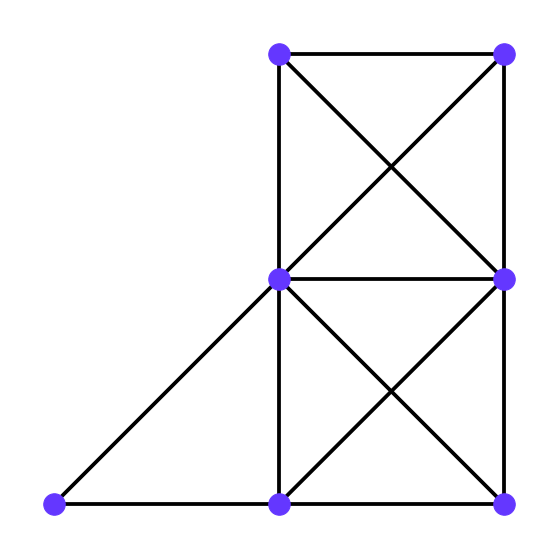

In [4]:
# Make a small king's graph
pos,small_G = kings_graph(3,3,0.8,seed = 1)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
visualize_graph(ax,small_G,pos)
plt.show()

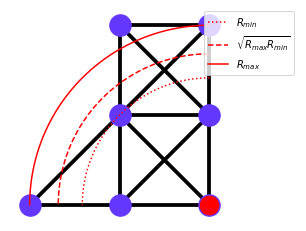

In [5]:
# Find unit disk radius
unitdisk_radius,min_radius,max_radius = find_UDG_radius(pos,small_G)

# Visualize using networkx
fig = plt.figure()
ax = plt.subplot(1,1,1)
visualize_graph(ax,small_G,pos)


# Draw the minimum and maximum unit disk radius of the graph
x0,y0 = (2,0)
angles = np.linspace(np.pi/2,np.pi,1001)
ax.plot(min_radius*np.cos(angles)+x0,min_radius*np.sin(angles)+y0,
        linestyle=":",color="red",label="$R_{min}$")
ax.plot(unitdisk_radius*np.cos(angles)+x0,unitdisk_radius*np.sin(angles)+y0,
        linestyle="--",color="red",label="$\sqrt{R_{max}R_{min}}$")
ax.plot(max_radius*np.cos(angles)+x0,max_radius*np.sin(angles)+y0,
        linestyle="-",color="red",label="$R_{max}$")

ax.scatter(x0,y0,color="red",zorder=3,marker="o",s=350)
ax.set_xlim((-0.25,3))
plt.legend(loc="upper right",)
plt.show()

Blockade radius of Rydberg system is 8.044e-06m
Unit disk radius of logical graph is 1.682


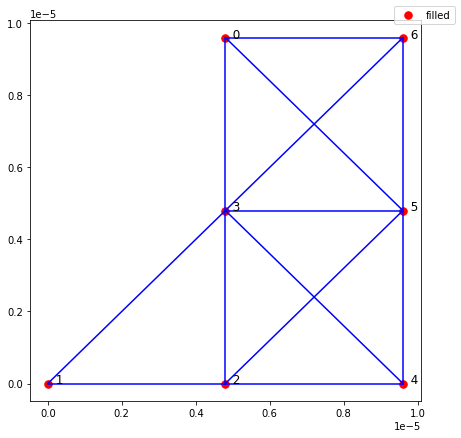

In [6]:
Delta_final = 20e6 # rad/sec

# Find blockade radius
blockade_radius = get_blockade_radius(Delta_final, 0) # no rabi amplitude at the end
print('Blockade radius of Rydberg system is {:0.3e}m'.format(blockade_radius))
print('Unit disk radius of logical graph is {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
a = blockade_radius / unitdisk_radius

# Generate the atom register
from braket.ahs.atom_arrangement import AtomArrangement
small_register = AtomArrangement()
for x in pos:
    small_register.add((a * x).round(7))
    
    
from quera_ahs_utils.plotting import show_register
show_register(small_register,blockade_radius = a*1.5)

In [7]:
# QAOA 
max_time = float(capabilities.rydberg.dict()['rydbergGlobal']['timeMax'])
time_res = float(capabilities.rydberg.dict()['rydbergGlobal']['timeResolution'])

max_rabi = float(capabilities.rydberg.dict()['rydbergGlobal']['rabiFrequencyRange'][1])
rabi_res = float(capabilities.rydberg.dict()['rydbergGlobal']['rabiFrequencyResolution'])

max_detuning = float(capabilities.rydberg.dict()['rydbergGlobal']['detuningRange'][1])
detuning_res = float(capabilities.rydberg.dict()['rydbergGlobal']['detuningResolution'])

max_slew_rate = min(
    float(capabilities.rydberg.dict()['rydbergGlobal']['detuningSlewRateMax']),
    float(capabilities.rydberg.dict()['rydbergGlobal']['rabiFrequencySlewRateMax'])
)
ramp_time = max_rabi/max_slew_rate # run = slope/rise. This is greater than time res

p = 3
time_without_ramps = max_time - 2*ramp_time*p
init_params = [(max_time - time_without_ramps)/6 for i in range(2*p)] # default params [mixer, cost]

In [8]:
# Constraint to ensure total time falls within maximum allowable time
def enforce_time_bound(x):
    return 0.000004*(10**6) - (sum(x) + (15800000.0*(10**6)/250000000000000.0)*(len(x)))

# Constraint to ensure all time durations are positive
def enforce_positive_params(x):
    for elem in x:
        if elem < 0:
            return -1 # penalty for negative parameter
    
    return 1

def objective(params):
    '''
    The objective function that the classical optimizer minimzes the parameters of.
    Runs evolution by given paramters
    
    params: a list of points in time, in picoseconds (so that the number is large enough for scipy to optimize). 
    '''
    
    scaled_params = [elem*10**(-6) for elem in params] # convert to microseconds
    
    # Check if constraints are violated
    for i in range(len(params)):
        if params[i] < 0:
            params[i] = 0
            
    if enforce_time_bound(params) < 0:
        for i in range(len(scaled_params)):
            scaled_params[i] = 0.000004*scaled_params[i]/((15800000.0*(10**6)/250000000000000.0)*(len(x)))
    
    time_points, amplitude_values, detuning_values, phase_values = get_ham_values(scaled_params)
    # Define the drive
    drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
    #show_global_drive(drive);
    
    small_ahs_program = AnalogHamiltonianSimulation(
        register=small_register, 
        hamiltonian=drive
    )
    
    # Define Device
    device = LocalSimulator("braket_ahs")
    small_ahs_run = device.run(small_ahs_program, shots=1000)
    
    # Run
    result  = small_ahs_run.result()
    
    # Store results in json string
    result_dict = {"measurements":[]}
    for measurement in result.measurements:
        shot_result = {
            "pre_sequence":[int(qubit) for qubit in measurement.pre_sequence],
            "post_sequence":[int(qubit) for qubit in measurement.post_sequence]
                      } 
        result_dict["measurements"].append(shot_result)
        
    #json.dumps(result_dict,io,indent=2) # dumps instead of dump to avoid saving file
    
    IS_sizes,pp_bitstrings = analysis_MIS(small_G,result_dict, print_extra=False)
    return -1*IS_sizes.mean() # Multiply by -1 since we want to minimze rather than maximize

# Constraint Dictionary
cons = (
    {
        'type': 'ineq', 
        'fun': enforce_time_bound # sum of times must be less than max time
    },
    {
        'type': 'ineq',
        'fun': enforce_positive_params
    }
)

init_params = [elem*10**6 for elem in init_params]
optimized_params = minimize(objective, init_params, method='COBYLA', constraints = cons, options = {'maxiter': 15})

Average post-processed IS size: 1.5027
Average post-processed IS size: 1.4800
Average post-processed IS size: 1.4118
Average post-processed IS size: 1.5027
Average post-processed IS size: 1.5267
Average post-processed IS size: 1.4738
Average post-processed IS size: 1.4689


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


ValidationError: 1 validation error for TimeSeriesValidator
__root__
  First time value is -7.733254666174099E-7; it must be 0.0 (type=value_error)

In [ ]:
scaled_optimal_params = [elem*(10**-6) for elem in optimized_params['x']]
time_points, amplitude_values, detuning_values, phase_values = get_ham_values(scaled_optimal_params)

drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

small_ahs_program = AnalogHamiltonianSimulation(
    register=small_register, 
    hamiltonian=drive
)

device = LocalSimulator("braket_ahs")
small_ahs_run = device.run(small_ahs_program, shots=1000)


# Results are loaded and saved to file
result  = small_ahs_run.result()
save_result_json("classical_results/small_kings_graph_mis_trial_1.json",result)

trial_file = "classical_results/small_kings_graph_mis_trial_1.json"
result_json = open_json(trial_file)
nmeas = len(result_json["measurements"])    
seqs = [result_json["measurements"][i]["post_sequence"] for i in [0,1,nmeas-1]]

fig = plt.figure(figsize=(25,15))

for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
    visualize_graph(ax,small_G,pos,node_colors = seqs_color)
    
plt.show()

In [ ]:
IS_sizes,pp_bitstrings = analysis_MIS(small_G,result_json)

In [ ]:
def objective(params):
    scaled_params = [elem*10**(-6) for elem in params]
    time_points, amplitude_values, detuning_values, phase_values = get_ham_values(scaled_params)
    # Define the drive
    drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
    #show_global_drive(drive);
    
    small_ahs_program = AnalogHamiltonianSimulation(
        register=small_register, 
        hamiltonian=drive
    )
    
    # Define Device
    #device = LocalSimulator("braket_ahs")
    device = qpu
    small_ahs_run = device.run(small_ahs_program, shots=1000)
    
    # Run
    result  = small_ahs_run.result()
    result_json = open_json("qaoa.json")
    nmeas = len(result_json["measurements"])
    seqs = [result_json["measurements"][i]["post_sequence"] for i in [0,nmeas-2,nmeas-1]]
    
    # Store results in json string
    result_dict = {"measurements":[]}
    for measurement in result.measurements:
        shot_result = {
            "pre_sequence":[int(qubit) for qubit in measurement.pre_sequence],
            "post_sequence":[int(qubit) for qubit in measurement.post_sequence]
                      } 
        result_dict["measurements"].append(shot_result)
        
    #json.dumps(result_dict,io,indent=2) # dumps instead of dump to avoid saving file
    
    IS_sizes,pp_bitstrings = analysis_MIS(small_G,result_dict, print_extra=False)
    return -1*IS_sizes.mean() # Multiply by -1 since we want to minimze rather than maximize


In [ ]:
scaled_optimal_params = [elem*(10**-6) for elem in optimized_params['x']]
time_points, amplitude_values, detuning_values, phase_values = get_ham_values(scaled_optimal_params)

drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

small_ahs_program = AnalogHamiltonianSimulation(
    register=small_register, 
    hamiltonian=drive
)

device = LocalSimulator("braket_ahs")
small_ahs_run = device.run(small_ahs_program, shots=1000)


# Results are loaded and saved to file
result  = small_ahs_run.result()
save_result_json("classical_results/small_kings_graph_mis_trial_1.json",result)

trial_file = "classical_results/small_kings_graph_mis_trial_1.json"
result_json = open_json(trial_file)
nmeas = len(result_json["measurements"])    
seqs = [result_json["measurements"][i]["post_sequence"] for i in [0,1,nmeas-1]]

fig = plt.figure(figsize=(25,15))

for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[seqs[i][j]] for j in range(len(seqs[i]))]
    visualize_graph(ax,small_G,pos,node_colors = seqs_color)
    
plt.show()

In [ ]:
IS_sizes,pp_bitstrings = analysis_MIS(small_G,result_json)